In [2]:
import math
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
csv = open('/content/gdrive/My Drive/Colab Notebooks/ML/Project/data/fer2013.csv')
df = pd.read_csv(csv)
print(df.shape) # (35887, 3)

df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
df.emotion.unique() # array([0, 2, 4, 6, 3, 5, 1])

df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [6]:
# Use test data only 
df.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [7]:
df = df[(df['Usage'] =='PublicTest') | (df['Usage'] =='PrivateTest')]
print(df.shape)
df.head()

(7178, 3)


,emotion,pixels,Usage
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...,PublicTest
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,PublicTest


In [8]:
df.emotion.unique() # array([0, 2, 4, 6, 3, 5, 1])

df.emotion.value_counts()

3    1774
4    1247
6    1233
2    1024
0     958
5     831
1     111
Name: emotion, dtype: int64

In [9]:
emotion_label_to_text = {
  0: 'anger',
  1: 'disgust',
  2: 'fear',
  3: 'happiness',
  4: 'sadness',
  5: 'surprise',
  6: 'neutral'
}

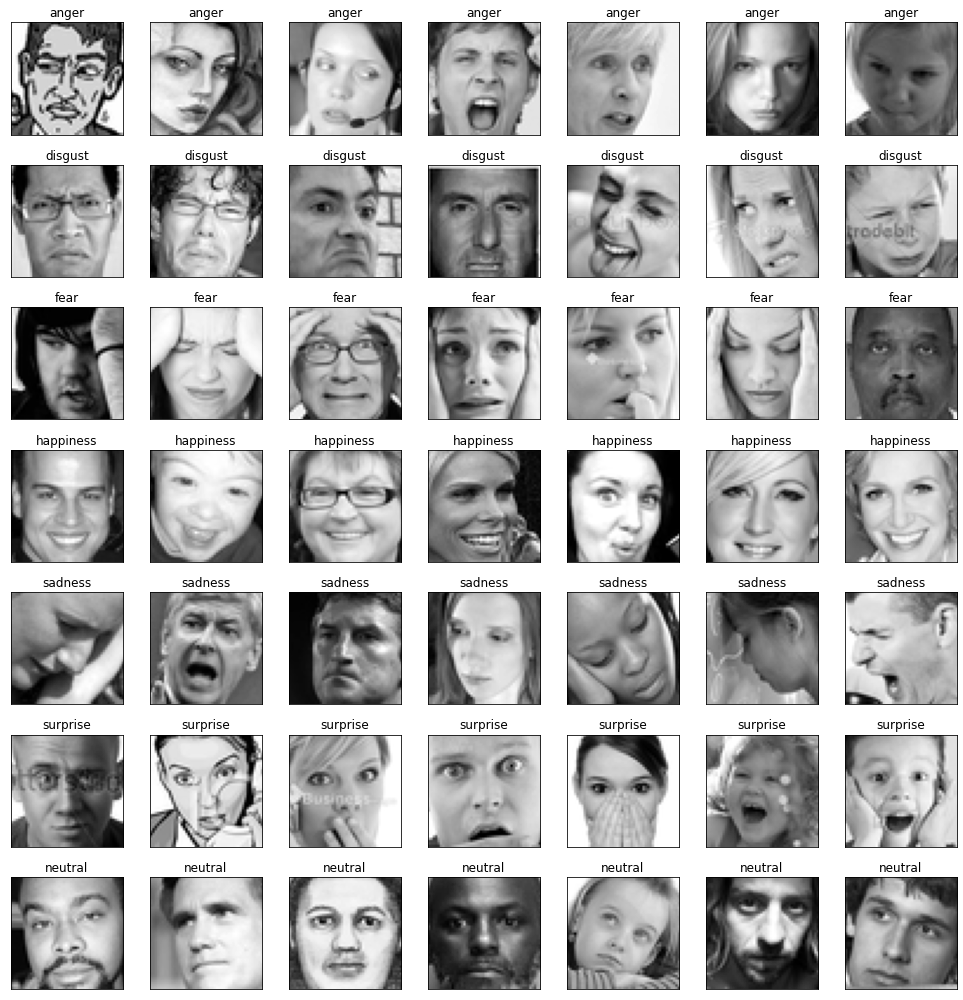

In [10]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [11]:
INTERESTED_LABELS = [3, 4, 6]

df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape # (21264, 3)

(4254, 3)

In [12]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)
img_array.shape # (21264, 48, 48, 1)

le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape # (21264, 3)

le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping # {3: 0, 4: 1, 6: 2}

{3: 0, 4: 1, 6: 2}

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(
  img_array,
  img_labels,
  shuffle=True, 
  stratify=img_labels,
  test_size=0.1, 
  random_state=42
)

del df
del img_array
del img_labels

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(3828, 48, 48, 1) (426, 48, 48, 1) (3828, 3) (426, 3)


In [14]:
# Normalizing arrays, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [15]:
def build_net(optim):
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [16]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [17]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(X_train)

In [18]:
batch_size = 32 #batch size of 32 performs the best.

epochs = 100

optims = [
  optimizers.Nadam(
      learning_rate=0.001,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      name='Nadam'),
    
  optimizers.Adam(0.001),
]

In [19]:
model = build_net(optims[1]) 

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/100
119/119 [==============================] - 308s 3s/step - loss: 1.6952 - accuracy: 0.3644 - val_loss: 1.6580 - val_accuracy: 0.3239 - lr: 0.0010
Epoch 2/100
119/119 [==============================] - 304s 3s/step - loss: 1.3625 - accuracy: 0.3871 - val_loss: 1.0744 - val_accuracy: 0.4460 - lr: 0.0010
Epoch 3/100
119/119 [==============================] - 310s 3s/step - loss: 1.1967 - accuracy: 0.4164 - val_loss: 1.0170 - val_accuracy: 0.4718 - lr: 0.0010
Epoch 4/100
119/119 [==============================] - 309s 3s/step - loss: 1.1205 - accuracy: 0.4287 - val_loss: 1.0227 - val_accuracy: 0.4859 - lr: 0.0010
Epoch 5/100
119/119 [==============================] - 309s 3s/step - loss: 1.0970 - accuracy: 0.4342 - val_loss: 1.0022 - val_accuracy: 0.4930 - lr: 0.0010
Epoch 6/100
119/119 [==============================] - 308s 3s/step - loss: 1.0596 - accuracy: 0.4519 - val_loss: 0.9852 - val_accuracy: 0.5329 - lr: 0.0010
Epoch 7/100
119/119 [==============================] - 308

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

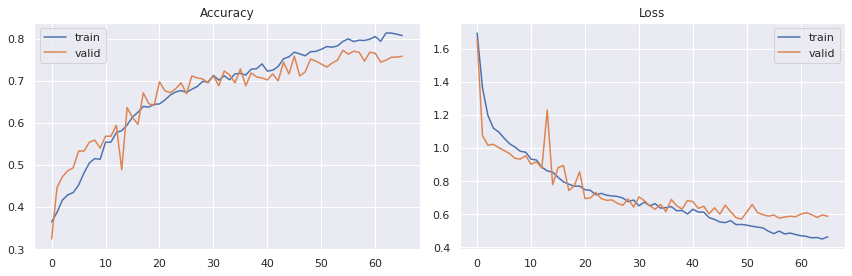

In [20]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

In [1]:
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

NameError: ignored

In [21]:
model.save("model.h5")

In [26]:
model.save("models")

INFO:tensorflow:Assets written to: models/assets


In [27]:
ls models/

assets/  keras_metadata.pb  saved_model.pb  variables/


In [34]:
ls gdrive/MyDrive/

 Class/  'Colab Notebooks'/


In [35]:
mv model.h5 gdrive/MyDrive/model.h5

In [36]:
from google.colab import files
files.download("gdrive/MyDrive/model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

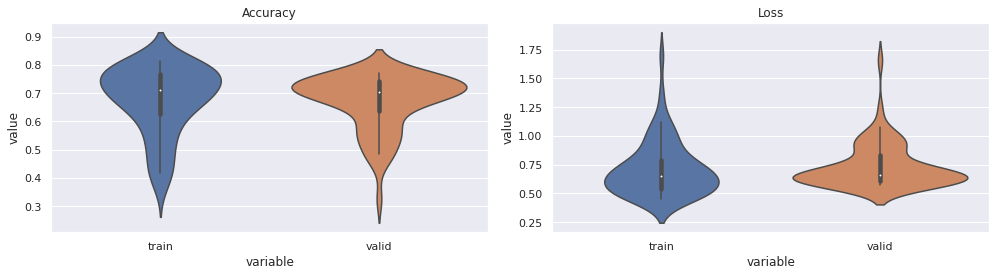

In [23]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

In [24]:
yhat_valid = model.predict_classes(X_valid)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))


AttributeError: ignored

AttributeError: ignored

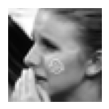

In [25]:
mapper = {
    0: "happy",
    1: "sad",
    2: "neutral",
}

np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pred:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:neut, p:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        pyplot.tight_layout()